In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline

torch.set_grad_enabled(False)

In [2]:
pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = 'mv_cat_statue:latest'
anim_tag = 'human_mv:latest'

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
cams, meshes = texture_anim.load_frames()
verts_uvs, faces_uvs = texture_anim.uv_data()

In [4]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
uvs = render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs)
vid = pil_frames_to_clip(uvs)

display_vids([vid], title=prompt)

In [22]:
from pathlib import Path
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.logging import H5Logger

decoder_paths = []

texgen_config = TexturingConfig(module_paths=decoder_paths, num_inference_steps=5)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

indices = torch.arange(len(cams), device="cuda")

images = pipe(
    prompt,
    meshes[indices],
    cams[indices],
    verts_uvs,
    faces_uvs,
    texgen_config=texgen_config,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

100%|██████████| 5/5 [00:25<00:00,  5.12s/it]


In [19]:
display_vid(pil_frames_to_clip(images))

801


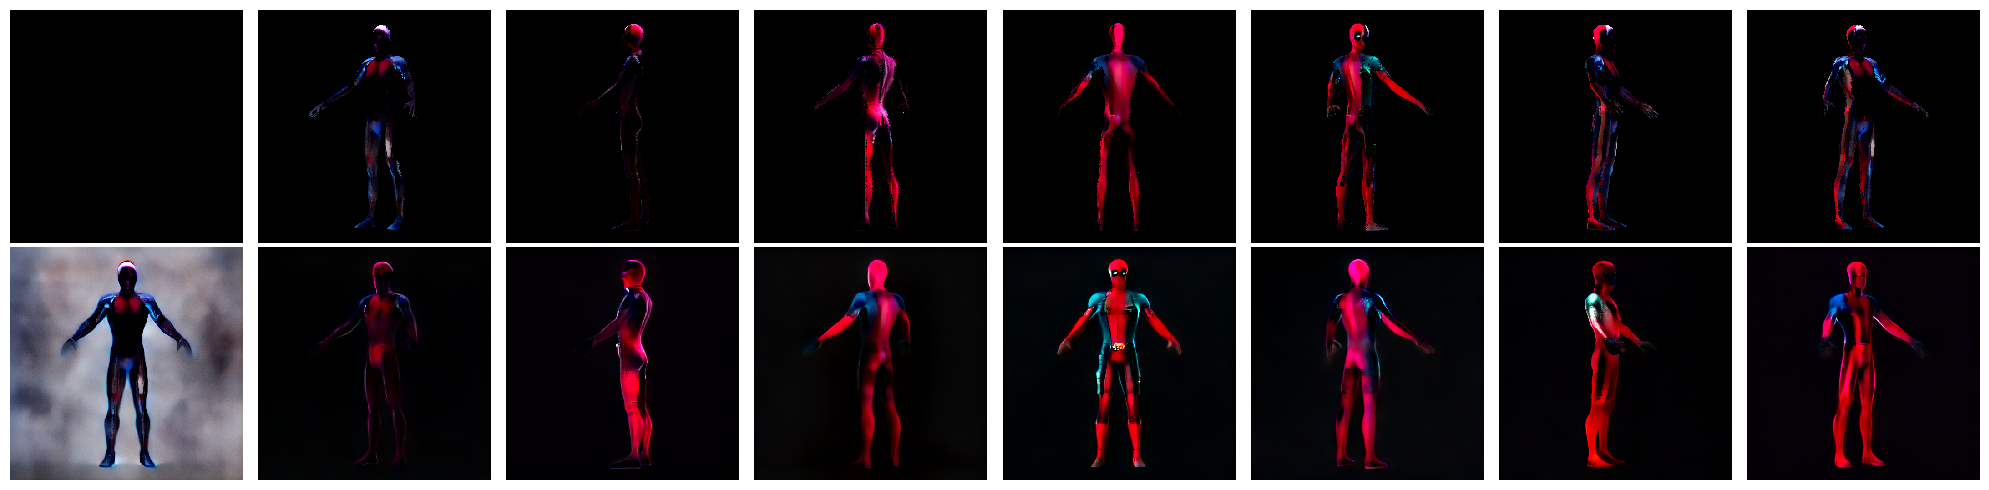

In [21]:
import torchvision.transforms.functional as TF

from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims_grid

ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_is = sorted(logger.key_values("clean_im", "frame_i"))

t_vis = ts[0]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]
rendered = [
    logger.read("rendered", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]

grid = object_array([rendered, clean_ims])
display_ims_grid(grid)

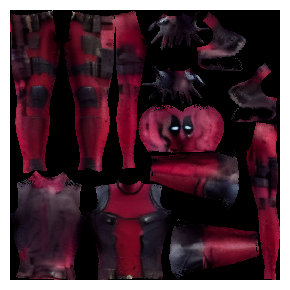

In [21]:
# project to texture
from text3d2video.backprojection import (
    aggregate_views_uv_texture_mean,
    compute_texel_projection,
)
from text3d2video.utilities.ipython_utils import display_ims


texture_res = 1000
projections = [
    compute_texel_projection(
        m, c, verts_uvs, faces_uvs, texture_res, raster_res=2000
    )
    for m, c in zip(meshes, cams)
]

texturing_frames_pt = [TF.to_tensor(f) for f in images]
texturing_frames_pt = torch.stack(texturing_frames_pt).cuda()
texture = aggregate_views_uv_texture_mean(texturing_frames_pt, texture_res, projections)

display_ims([texture.cpu()])

In [22]:
texture = logger.read("clean_tex", t=ts[-1]).cuda()
display_ims([texture.cpu()])

NameError: name 'ts' is not defined

In [23]:
from text3d2video.rendering import render_texture


anim = AnimationArtifact.from_wandb_artifact_tag("rumba_20:latest")
anim_cams, anim_meshes = anim.load_frames()
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

renders = render_texture(
    anim_meshes, anim_cams, texture, anim_verts_uvs, anim_faces_uvs, return_pil=True
)

display_vid(pil_frames_to_clip(renders))